# BERT FINETUNING

## Import Libraries

In [1]:
import pandas as pd

DATA_PATH = "https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/master/twitter_multi_class_sentiment.csv"
df: pd.DataFrame = pd.read_csv(filepath_or_buffer=DATA_PATH)
df.shape

(16000, 3)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        16000 non-null  object
 1   label       16000 non-null  int64 
 2   label_name  16000 non-null  object
dtypes: int64(1), object(2)
memory usage: 375.1+ KB


In [3]:
df

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger
...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,sadness
15996,i am now turning and i feel pathetic that i am...,0,sadness
15997,i feel strong and good overall,1,joy
15998,i feel like this was such a rude comment and i...,3,anger


In [4]:
df["label_name"].value_counts(normalize=True) * 100

label_name
joy         33.51250
sadness     29.16250
anger       13.49375
fear        12.10625
love         8.15000
surprise     3.57500
Name: proportion, dtype: float64

Text(0.5, 1.0, 'Frequency of Classes')

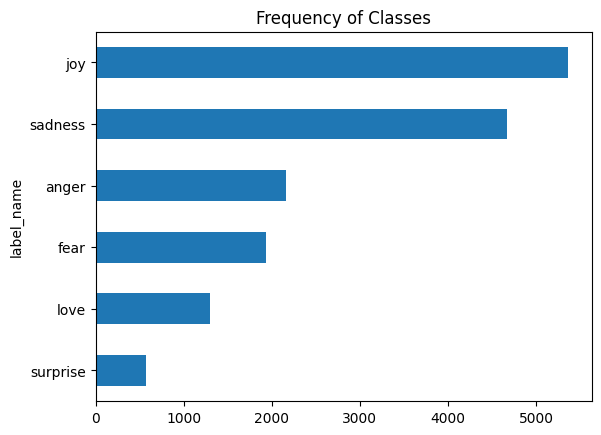

In [5]:
import matplotlib.pyplot as plt
from pandas import Series

label_counts = df["label_name"].value_counts(ascending=True)
label_counts.plot.barh()
plt.title(label="Frequency of Classes")

In [6]:
df["Words per Tweet"] = df["text"].str.split().apply(func=len)
df

,text,label,label_name,Words per Tweet
0,i didnt feel humiliated,0,sadness,4
1,i can go from feeling so hopeless to so damned...,0,sadness,21
2,im grabbing a minute to post i feel greedy wrong,3,anger,10
3,i am ever feeling nostalgic about the fireplac...,2,love,18
4,i am feeling grouchy,3,anger,4
...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,sadness,24
15996,i am now turning and i feel pathetic that i am...,0,sadness,20
15997,i feel strong and good overall,1,joy,6
15998,i feel like this was such a rude comment and i...,3,anger,14


<AxesSubplot:title={'center':'Words per Tweet'}, xlabel='label_name'>

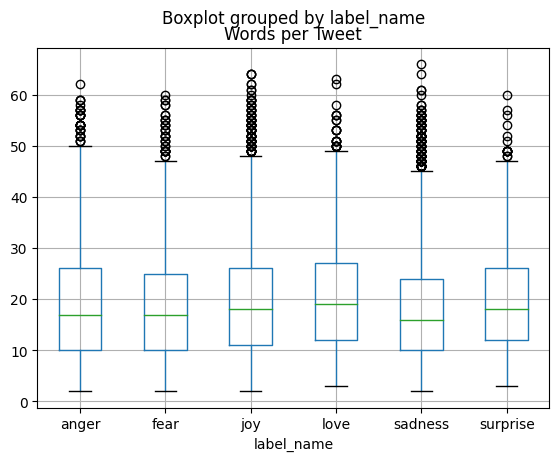

In [7]:
df.boxplot(column="Words per Tweet", by="label_name")

## Tokenization

In [8]:
from transformers import AutoTokenizer
from transformers.tokenization_utils import PreTrainedTokenizer
from transformers.tokenization_utils_fast import PreTrainedTokenizerFast

In [9]:
model_checkpoint = "bert-base-uncased"
tokenizer: PreTrainedTokenizer | PreTrainedTokenizerFast = (
    AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_checkpoint)
)

In [10]:
tokenizer

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [11]:
from transformers.tokenization_utils_base import BatchEncoding


text = "Hey! How are you?"
encoded_input: BatchEncoding = tokenizer(text)
print(len(encoded_input))
print(encoded_input)

3
{'input_ids': [101, 4931, 999, 2129, 2024, 2017, 1029, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}


In [12]:
len(tokenizer.vocab), tokenizer.vocab_size, tokenizer.model_max_length

(30522, 30522, 512)

## Data Loader and Train Test Split

In [15]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, stratify=df["label_name"])
test, val = train_test_split(test, test_size=1 / 3, stratify=test["label_name"])

train.shape, test.shape, val.shape

((11200, 4), (3200, 4), (1600, 4))

In [18]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict(
    {
        "train": Dataset.from_pandas(df=train, preserve_index=False),
        "test": Dataset.from_pandas(df=test, preserve_index=False),
        "val": Dataset.from_pandas(df=val, preserve_index=False),
    }
)

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 3200
    })
    val: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 1600
    })
})

# Tokenization

In [21]:
from transformers.tokenization_utils_base import BatchEncoding


def tokenize(batch) -> BatchEncoding:
    return tokenizer(batch["text"], truncation=True)

In [24]:
print(dataset["train"][0:2])
print(tokenize(batch=dataset["train"][0:2]))

{'text': ['i also have the feeling i need a very relaxed practice today', 'i wanted to make sure i didnt feel rushed getting to century college on friday afternoon'], 'label': [1, 3], 'label_name': ['joy', 'anger'], 'Words per Tweet': [12, 16]}
{'input_ids': [[101, 1045, 2036, 2031, 1996, 3110, 1045, 2342, 1037, 2200, 8363, 3218, 2651, 102], [101, 1045, 2359, 2000, 2191, 2469, 1045, 2134, 2102, 2514, 6760, 2893, 2000, 2301, 2267, 2006, 5958, 5027, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [25]:
from datasets.dataset_dict import DatasetDict


encoded_data: DatasetDict = dataset.map(
    function=tokenize, batched=True, batch_size=None
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Map:   0%|          | 0/11200 [00:00<?, ? examples/s]

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

In [26]:
encoded_data

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3200
    })
    val: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1600
    })
})

In [27]:
for x in dataset["train"]:
    print(x)
    break

{'text': 'i also have the feeling i need a very relaxed practice today', 'label': 1, 'label_name': 'joy', 'Words per Tweet': 12}


In [28]:
# mapping with label2id, id2label

label2id = {x["label_name"]: x["label"] for x in dataset["train"]}
id2label = {x["label"]: x["label_name"] for x in dataset["train"]}

print(label2id)
print(id2label)

{'joy': 1, 'anger': 3, 'sadness': 0, 'fear': 4, 'love': 2, 'surprise': 5}
{1: 'joy', 3: 'anger', 0: 'sadness', 4: 'fear', 2: 'love', 5: 'surprise'}


## Model Config

In [29]:
from transformers import AutoModel
import torch

model_checkpoint

'bert-base-uncased'

In [30]:
model = AutoModel.from_pretrained(pretrained_model_name_or_path=model_checkpoint)

print(model)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [31]:
model.config.architectures

['BertForMaskedLM']

In [32]:
model.config.hidden_size

768

In [33]:
model.config

BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.46.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

## Loading Model

In [37]:
num_labels: int = len(label2id)
print(num_labels)

device = torch.device(device="cuda" if torch.cuda.is_available() else "cpu")
print(device)

6
cpu


In [38]:
from transformers import AutoModelForSequenceClassification, AutoConfig

config = AutoConfig.from_pretrained(
    pretrained_model_name_or_path=model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    num_labels=num_labels,
)

model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path=model_checkpoint, config=config
).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [40]:
model.config

BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "sadness",
    "1": "joy",
    "2": "love",
    "3": "anger",
    "4": "fear",
    "5": "surprise"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 3,
    "fear": 4,
    "joy": 1,
    "love": 2,
    "sadness": 0,
    "surprise": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.46.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

## Building Training Arguments

In [41]:
from transformers import Trainer, TrainingArguments

BATCH_SIZE = 64
TRAINING_DIR = "bert_base_train"

training_args = TrainingArguments(
    learning_rate=2e-5,
    output_dir=TRAINING_DIR,
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    evaluation_strategy="epoch",
    weight_decay=0.01,
    disable_tqdm=False,
)

/Users/admin/Library/Caches/pypoetry/virtualenvs/llm-engineering-RAtdaHMm-py3.12/lib/python3.12/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## Compute Metrics

In [45]:
import evaluate
import numpy as np

accuracy: evaluate.EvaluationModule = evaluate.load("accuracy")


def compute_metrics_evaluate(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(a=predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [46]:
# Use skleaarn if not want to use evaluate
from sklearn.metrics import accuracy_score, f1_score


def compute_metrics_sklearn(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

## Build Trainer

In [48]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 3200
    })
    val: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 1600
    })
})

In [50]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_data["train"],
    eval_dataset=encoded_data["val"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics_sklearn,
)

/var/folders/pp/3zwp4_s56jb51k20dlwb3v8h0000gn/T/ipykernel_12797/2543496065.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [51]:
trainer.train()

  0%|          | 0/525 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Model Evaluation

In [ ]:
from transformers.trainer_utils import PredictionOutput


preds_output: PredictionOutput = trainer.predict(test_dataset=encoded_data["test"])
preds_output.metrics

In [ ]:
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = encoded_data["test"][:]["label"]

In [52]:
from sklearn.metrics import classification_report

classification_report(y_true, y_pred)

NameError: name 'y_true' is not defined

## Confusion Matrix

In [53]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(
    data=cm,
    annot=True,
    fmt="d",
    xticklabels=label2id.keys(),
    yticklabels=label2id.keys(),
    cbar=False,
    cmap="Reds",
)
plt.title(label="Confusion matrix")
plt.ylabel(ylabel="Actual label")
plt.xlabel(xlabel="Predicted label")

NameError: name 'y_true' is not defined

## Save Model

In [ ]:
text = "I am super happy today. I have got it done. Finally!!!"


def get_prediction(text):
    input_encoded = tokenizer(text, return_tensors="pt").to(device=device)

    with torch.no_grad():
        outputs = model(**input_encoded)

    logits = outputs.logits

    pred = torch.argmax(logits, axis=1).item()
    return id2label[pred]


get_prediction(text)

{'input_ids': tensor([[ 101, 1045, 2572, 3565, 3407, 2651, 1012, 1045, 2031, 2288, 2009, 2589,
         1012, 2633,  999,  999,  999,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
trainer.save_model("bert-base-uncased-sentiment")

## Use the finetuned model

In [ ]:
from transformers import pipeline

classifier = pipeline("text-classification", model="bert-base-uncased-sentiment")
print(classifier(text))
print(classifier(text))

## Push Model to HuggingFace Hub

In [ ]:
from huggingface_hub import login, HfApi, Repository
from transformers import PreTrainedModel, PreTrainedTokenizer


def push_to_hub(
    model: PreTrainedModel,
    tokenizer: PreTrainedTokenizer,
    model_name: str,
    username: str,
    commit_message: str = "Add fine-tuned model",
):
    """
    Push a fine-tuned model and tokenizer to Hugging Face Model Hub.

    Args:
    model (PreTrainedModel): The fine-tuned model to push.
    tokenizer (PreTrainedTokenizer): The tokenizer associated with the model.
    model_name (str): The name to give to the model on the Hub.
    username (str): Your Hugging Face username.
    commit_message (str, optional): The commit message for the push. Defaults to "Add fine-tuned model".

    Returns:
    str: The URL of the pushed model on the Hugging Face Model Hub.
    """
    # Log in to Hugging Face
    login()

    # Set up repository information
    repo_name = f"{username}/{model_name}"

    # Create a new repository on Hugging Face
    api = HfApi()
    api.create_repo(repo_id=repo_name, exist_ok=True)

    # Clone the repository locally
    repo = Repository(local_dir=model_name, clone_from=repo_name)

    # Save your model and tokenizer
    model.save_pretrained(model_name)
    tokenizer.save_pretrained(model_name)

    # Push the files to your Hugging Face repository
    repo.git_add()
    repo.git_commit(commit_message)
    repo.git_push()

    return f"Model pushed to https://huggingface.co/{repo_name}"


result = push_to_hub(model, tokenizer, "my-awesome-model", "my-username")
print(result)
